# Topic/User Analysis

## Load Data

In [1]:
import pandas as pd
import numpy as np

chosen_dataset = 'covid_tweets_en'
chosen_dataset = 'ukraine_tweets_en'
chosen_dataset = 'cop26_tweets_en'
ur_df = pd.read_parquet('./../../data/raw/'+chosen_dataset+'.parquet')
doc_info = pd.read_csv('./../../data/processed/document_info_'+chosen_dataset+'.csv')[['Document', 'Topic', 'Representative_document','Name']]
doc_info.Topic = doc_info.Topic.astype(int)
#embeddings = np.load('./../../data/processed/'+chosen_dataset+'.parquet.npy')

In [2]:
print(doc_info.columns)

Index(['Document', 'Topic', 'Representative_document', 'Name'], dtype='object')


In [3]:
usr_info = pd.read_csv("./../../data/raw/political_stance_merged.csv")
print(usr_info.columns) # merge on 'username'

Index(['username', 'political_leaning', 'reliability'], dtype='object')


## Merge dataset
Merge Topic data with Tweets so that retweets are included.

In [4]:
# merge ur_df with doc_info on 'text'
merged_df = ur_df.merge(doc_info, left_on='text', right_on='Document', how='left')
assert len(merged_df) == len(ur_df), 'differing length before and after merge, duplicates in right'

In [5]:
# change type of 'author_id' to string
ur_df['author_id'] = ur_df['author_id'].astype(str) 

In [6]:
ur_df.columns

Index(['id', 'author_id', 'created_at', 'lang', 'text', 'retweeted_id',
       'quoted_id', 'replied_id', 'url', 'expanded_url', 'hashtags',
       'retweet_count', 'reply_count', 'like_count', 'quote_count', 'username',
       'individual_or_org', 'category'],
      dtype='object')

## Assign Topic to Users
Many strategies were employed to assign topics to users, resulting in different retention percentages and interpretations.
- frequency: easy interpretation, higher retention.
- entropy: clearer interpretation, lower retention.

Both strategies return the most common topic.
In each case noise topic is excluded from computation.
If no topic is found that meets the requirements, no topic is assigned.


### Frequency to assign Topics to Users
Group topics by users, and assign the dominant topic using a frequency threshold.

The most frequent topic that exceeds exceeds the threshold, it is assigned to a user as the dominant one.
On ties, the topic with lowest id is assigned.

**TLDR: Frequency = Raw numbers**

In [7]:
# Function to select dominant topics
from collections import Counter

def get_user_frequent_topic(topics, threshold=0.5, exclude=-1):
    """
    Args:
        topics (list): list of topic labels for a user.
        threshold (float): minimum fraction (e.g., 0.5 for 50%) for frequence.
        exclude (int or list): topic(s) to exclude, e.g. -1 for bertopic Noise.
    
    Returns:
        int or None: dominant topic if above threshold, else None
    """
    if isinstance(exclude, int):
        topics = [t for t in topics if t != exclude]
    elif isinstance(exclude, list):
        topics = [t for t in topics if t not in exclude]

    if not topics:
        return None

    total = len(topics)
    topic_counts = Counter(topics)
    top_topic, top_count = topic_counts.most_common(1)[0]
    
    if top_count / total >= threshold:
        return int(top_topic)
    return None


### Entropy to assign Topics to Users

If we want to assign topics unambigously to all users, we can use entropy to assign them.

We assign a topic only if entropy of the user's topic distribution is low, i.e., user is focused.
To do so, we compute entropy of users' topic distributions, excluding noise (topic -1).

Then, we prevent the assignment of topics in the presence of ties.

**TLDR: Entropy = User Focus**
| Entropy | Interpretation                                             |
| ------- | ---------------------------------------------------------- |
| 0       | All tweets in one topic (perfect focus)                    |
| \~1     | Tweets mostly in 2 topics                                  |
| \~2     | Tweets across 4 topics fairly evenly                       |
| \~3     | Tweets across \~8 topics                                   |
| \~4     | Tweets across \~16 topics                                  |
| ...     | ... (upper limit is $\log_2(N)$, where $N$ = total topics) |


In [94]:
# Function to select dominant topic using entropy to theshold it.
from scipy.stats import entropy
#from collections import Counter
import numpy as np
from math import log2


def get_user_dominant_topic(topics, max_entropy=log2(3), exclude=-1):
    """
    Args:
        topics (list): list of topic labels for a user.
        max_entropy (float): maximum allowed entropy. If user's topic distribution exceeds this, no dominant topic is assigned.
        exclude (int or list): topic(s) to exclude, e.g. -1 for noise.
    
    Returns:
        int or None: dominant topic if above threshold, else None
    """
    if isinstance(exclude, int):
        topics = [t for t in topics if t != exclude]
    elif isinstance(exclude, list):
        topics = [t for t in topics if t not in exclude]

    if not topics:
        return None

    topic_counts = Counter(topics)
    topic_probs = np.array(list(topic_counts.values())) / len(topics)
    
    most_common = topic_counts.most_common(2)
    if len(most_common)>1 and most_common[0][1] == most_common[1][1]:
        return None

    top_topic, _ = most_common[0]
    
    if entropy(topic_probs) < max_entropy:
        return int(top_topic)
    return None

topic_test = [0,0,0,0,0,0,2,2,2,2,2,1,1,1,3,4,5]
test_topic_counts = Counter(topic_test)

#print(f"most common topic: {get_user_dominant_topic(topic_test)}")

In [95]:
def topic_entropy(topics, exclude = -1):

    if isinstance(exclude, int):
        topics = [t for t in topics if t != exclude]
    elif isinstance(exclude, list):
        topics = [t for t in topics if t not in exclude]
    if not topics:
        return None
        
    counts = Counter(topics)
    probs = np.array(list(counts.values())) / len(topics)
    return entropy(probs)

#### User Retention
Different strategies lead to different assignments to users.
Frequency strategy assigns topics to less users with higher frequency, whereas lower frequencies lead to more deterministic assignments.
Entropy is able to assign more users with a dominant topic with low thresholds, but still 5% of users are left with unassigned topics with a maximum entropy of 3 (8 or more prevalent topics).

Arguably, entropy is a sounder strategy.

In [103]:
def Log2(x):
    return round(log2(x), 2)

user_topics = merged_df.groupby('author_id')['Topic'].apply(list)

# Compute entropy of topic distributions among users.
user_topic_entropy = user_topics.apply(lambda topics: topic_entropy(topics))

# try with log₂(2)=1 max entropy
user_dominant_topic_1 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(2)))

# try with log₂(3) max entropy
user_dominant_topic_1_5 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(3)))

# Try with log₂(4)=2 max entropy
user_dominant_topic_2 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(4)))

# Try with log₂(6) max entropy
user_dominant_topic_2_3 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(5)))

# Try with log₂(5) max entropy
user_dominant_topic_2_5 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(6)))

# Try with log₂(8)=3 max entropy
user_dominant_topic_3 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(8)))

user_frequent_topic_60 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=.6))
user_frequent_topic_50 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=.5))
user_frequent_topic_30 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=.3))
user_frequent_topic_20 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=.2))
user_frequent_topic_10 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=.1))

# Combine into a DataFrame for comparison
result = pd.DataFrame({
    'topic_entropy' : user_topic_entropy,
    'effective_topic_number':np.exp2(user_topic_entropy),
    'dominant_topic_2': user_dominant_topic_1,
    'dominant_topic_3':user_dominant_topic_1_5,
    'dominant_topic_4': user_dominant_topic_2,
    'dominant_topic_5':user_dominant_topic_2_3,
    'dominant_topic_6':user_dominant_topic_2_5,
    'dominant_topic_8': user_dominant_topic_3,
    'frequent_topic_60':user_frequent_topic_60,
    'frequent_topic_50':user_frequent_topic_50,
    'frequent_topic_30':user_frequent_topic_30,
    'frequent_topic_20':user_frequent_topic_20,
    'frequent_topic_10':user_frequent_topic_10
})

print(f"User retention with H<{Log2(2)=} max entropy:\t{100-float(round(result.dominant_topic_2.isna().sum()/len(result), 2)*100)}%")
print(f"User retention with H<{Log2(3)=} max entropy:\t{100-float(round(result.dominant_topic_3.isna().sum()/len(result), 2)*100)}%")
print(f"User retention with H<{Log2(4)=} max entropy:\t{100-float(round(result.dominant_topic_4.isna().sum()/len(result), 2)*100)}%")
print(f"User retention with H<{Log2(5)=} max entropy:\t{100-float(round(result.dominant_topic_5.isna().sum()/len(result), 2)*100)}%")
print(f"User retention with H<{Log2(6)=} max entropy:\t{100-float(round(result.dominant_topic_6.isna().sum()/len(result), 2)*100)}%")
print(f"User retention with H<{Log2(8)=} max entropy:\t{100-float(round(result.dominant_topic_8.isna().sum()/len(result), 2)*100)}%")
print(f'User retention with frequency ≥{60}%:\t{100-float(round(result.frequent_topic_60.isna().sum()/len(result), 2)*100)}%')
print(f'User retention with frequency ≥{50}%:\t{100-float(round(result.frequent_topic_50.isna().sum()/len(result), 2)*100)}%')
print(f'User retention with frequency ≥{30}%:\t{100-float(round(result.frequent_topic_30.isna().sum()/len(result), 2)*100)}%')
print(f'User retention with frequency ≥{20}%:\t{100-float(round(result.frequent_topic_20.isna().sum()/len(result), 2)*100)}%')
print(f'User retention with frequency ≥{10}%:\t{100-float(round(result.frequent_topic_10.isna().sum()/len(result), 2)*100)}%')
result

User retention with H<Log2(2)=1.0 max entropy:	5.0%
User retention with H<Log2(3)=1.58 max entropy:	18.0%
User retention with H<Log2(4)=2.0 max entropy:	37.0%
User retention with H<Log2(5)=2.32 max entropy:	57.0%
User retention with H<Log2(6)=2.58 max entropy:	76.0%
User retention with H<Log2(8)=3.0 max entropy:	95.0%
User retention with frequency ≥60%:	14.0%
User retention with frequency ≥50%:	24.0%
User retention with frequency ≥30%:	52.0%
User retention with frequency ≥20%:	81.0%
User retention with frequency ≥10%:	100.0%


,topic_entropy,effective_topic_number,dominant_topic_2,dominant_topic_3,dominant_topic_4,dominant_topic_5,dominant_topic_6,dominant_topic_8,frequent_topic_60,frequent_topic_50,frequent_topic_30,frequent_topic_20,frequent_topic_10
author_id,,,,,,,,,,,,,
612473,2.765118,6.798037,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
621533,2.813321,7.029007,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
742143,2.929291,7.617362,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0
759251,2.710703,6.546404,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
788524,2.873135,7.326557,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409806668200873984,1.623941,3.082159,NaN,NaN,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
1417393600019718145,0.125190,1.090651,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
1444231647038169090,1.151947,2.222136,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# change index type of 'result' to string
result.index = result.index.astype(str)

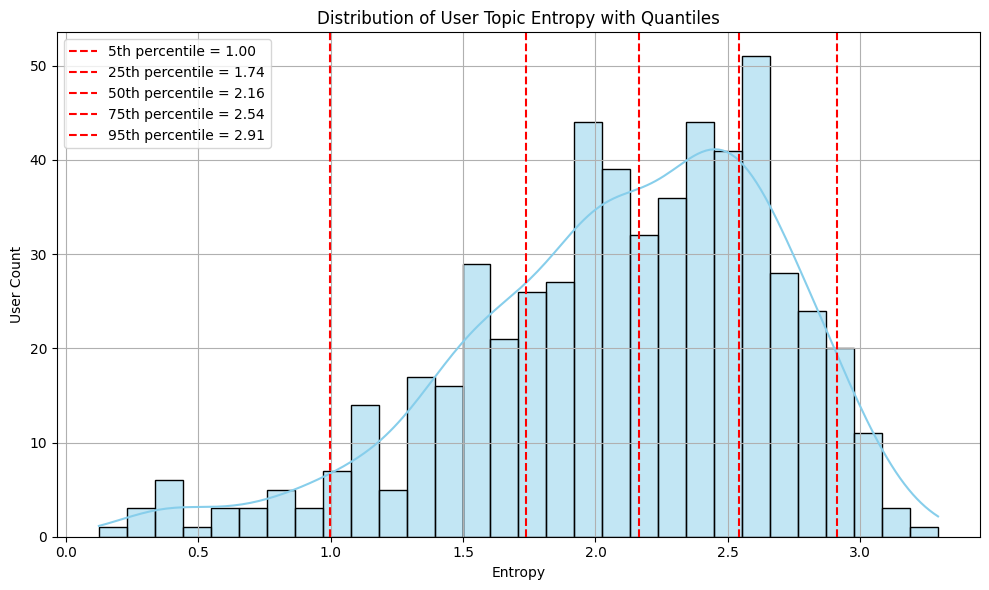

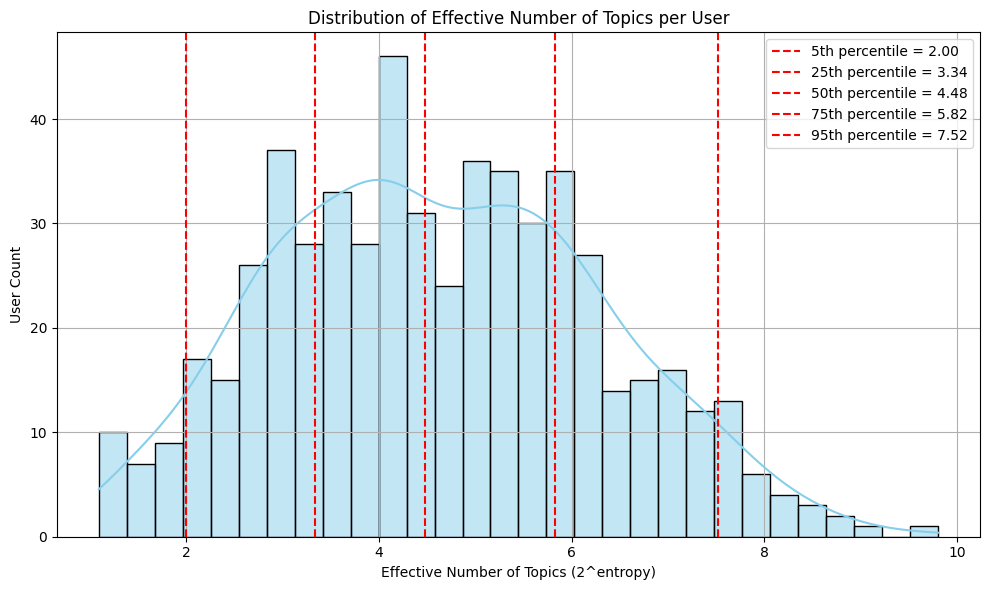

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_entropy_distribution(entropy_series, bins=30, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Plot the distribution of entropy values from a pandas Series with quantile lines.
    
    Args:
        entropy_series (pd.Series): Entropy values per user.
        bins (int): Number of bins for histogram.
        quantiles (list): List of quantile values to plot (e.g., [0.25, 0.5, 0.75]).
    """
    entropy_series = entropy_series.dropna()
    q_values = entropy_series.quantile(quantiles)

    plt.figure(figsize=(10, 6))
    sns.histplot(entropy_series, bins=bins, kde=True, color='skyblue', edgecolor='black')

    for q, val in zip(quantiles, q_values):
        plt.axvline(x=val, color='red', linestyle='--', linewidth=1.5, label=f'{int(q*100)}th percentile = {val:.2f}')

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Distribution of User Topic Entropy with Quantiles")
    plt.xlabel("Entropy")
    plt.ylabel("User Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_entropy_distribution(user_topic_entropy)

def plot_effective_topic_count(entropy_series, bins=30, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Plot distribution of effective number of topics (2^entropy) with quantile lines.
    
    Args:
        entropy_series (pd.Series): Entropy values per user.
        bins (int): Number of bins in histogram.
        quantiles (list): Quantile values to annotate.
    """
    entropy_series = entropy_series.dropna()
    effective_topics = np.exp2(entropy_series)
    q_values = effective_topics.quantile(quantiles)

    plt.figure(figsize=(10, 6))
    sns.histplot(effective_topics, bins=bins, kde=True, color='skyblue', edgecolor='black')

    for q, val in zip(quantiles, q_values):
        plt.axvline(x=val, color='red', linestyle='--', linewidth=1.5, label=f'{int(q*100)}th percentile = {val:.2f}')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Distribution of Effective Number of Topics per User")
    plt.xlabel("Effective Number of Topics (2^entropy)")
    plt.ylabel("User Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_effective_topic_count(user_topic_entropy)

In [ ]:
# Examples of users with focus on 8 or more topics 
for r in user_topics.iloc[np.where(user_topic_entropy > 3)]:
    r = np.array(r)
    if len(r[np.where(r!=-1)])>0:
        
        print(Counter(r[np.where(r!=-1)].tolist()))

Counter({0: 28, 2: 26, 14: 13, 15: 12, 18: 7, 5: 6, 25: 5, 1: 5, 13: 5, 23: 5, 4: 4, 24: 4, 10: 4, 16: 4, 17: 4, 6: 3, 11: 3, 26: 3, 3: 3, 12: 2, 47: 2, 31: 2, 8: 2, 21: 2, 36: 2, 39: 1, 20: 1, 28: 1, 33: 1, 37: 1, 19: 1, 9: 1, 27: 1, 35: 1, 7: 1})
Counter({0: 110, 6: 91, 2: 63, 1: 44, 11: 39, 18: 39, 25: 38, 14: 38, 15: 34, 13: 33, 7: 24, 10: 22, 23: 22, 5: 19, 20: 18, 4: 16, 28: 15, 16: 13, 38: 12, 9: 12, 24: 11, 31: 11, 12: 11, 3: 10, 47: 10, 33: 7, 35: 6, 27: 5, 17: 5, 30: 4, 19: 4, 29: 3, 40: 3, 8: 1, 41: 1, 46: 1, 39: 1})
Counter({6: 97, 0: 80, 1: 67, 2: 54, 23: 40, 25: 32, 15: 30, 18: 21, 31: 20, 20: 19, 5: 19, 14: 18, 9: 16, 11: 12, 13: 11, 10: 11, 7: 10, 35: 9, 4: 9, 40: 9, 38: 7, 16: 6, 47: 6, 19: 5, 8: 5, 12: 5, 37: 4, 30: 4, 24: 4, 21: 4, 3: 3, 46: 3, 33: 3, 26: 2, 36: 2, 29: 2, 39: 1, 45: 1, 27: 1, 17: 1})
Counter({2: 28, 11: 21, 18: 19, 1: 18, 15: 12, 6: 6, 16: 5, 30: 5, 33: 5, 31: 4, 3: 4, 0: 4, 25: 4, 7: 4, 14: 4, 10: 4, 5: 4, 4: 4, 20: 3, 9: 3, 26: 3, 40: 3, 13: 3, 23:

Topics are floats because some topics are NaN.

Will eliminate NaN and convert dtype to int when final results will be added

## Combine with user metadata
Load metadata and explore results

In [20]:
# `user_metadata` is a DataFrame with columns like:
# 'id', 'individual_or_org', 'category'
if chosen_dataset == 'cop26_tweets_en':
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_cop26.csv")
elif chosen_dataset == 'covid_tweets_en':
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_covid.csv")
elif chosen_dataset == 'ukraine_tweets_en':
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_ru_ukr.csv")
#print(f"{result.index.dtype}")
user_metadata.id = user_metadata.id.astype(str)
print(f"{user_metadata['id'].dtype=}")
user_metadata.columns

user_metadata['id'].dtype=dtype('O')


Index(['id', 'username', 'individual_or_org', 'category', 'num_of_rt',
       'num_of_retweeters', 'V1', 'followers_count', 'following_count',
       'tweet_count', 'listed_count'],
      dtype='object')

In [21]:
print(f"{result.index.dtype=}")

#combined_df = combined_df.merge(usr_info, left_on='username', right_on='username',how='left')

result.index.dtype=dtype('O')


In [ ]:
# Merge with user-topic assignments from previous step
combined_df = user_metadata.merge(result, left_on='id', right_on='author_id')
# Merge with information on users: political_leaning and reliability
combined_df = combined_df.merge(usr_info, on='username', how='left')

Use crosstabs and grouped bar plots to explore distributions.

In [25]:
pd.crosstab(combined_df['individual_or_org'], combined_df['dominant_topic_50'], normalize='index')

dominant_topic_50,1.0,2.0,6.0,7.0,8.0,9.0,10.0,15.0,18.0,19.0,...,57.0,63.0,64.0,65.0,87.0,110.0,112.0,125.0,131.0,158.0
individual_or_org,,,,,,,,,,,,,,,,,,,,,
Individual,0.000000,0.032258,0.129032,0.032258,0.032258,0.000000,0.000000,0.000000,0.032258,0.032258,...,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.064516,0.000000,0.000000,0.000000
Organization,0.363636,0.000000,0.045455,0.000000,0.000000,0.045455,0.090909,0.045455,0.000000,0.045455,...,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.045455


In [26]:
pd.crosstab(combined_df['category'], combined_df['dominant_topic_50'], normalize='index')

dominant_topic_50,1.0,2.0,6.0,7.0,8.0,9.0,10.0,15.0,18.0,19.0,...,57.0,63.0,64.0,65.0,87.0,110.0,112.0,125.0,131.0,158.0
category,,,,,,,,,,,,,,,,,,,,,
Activist,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000,0.5,0.000000,0.000000,0.25,0.000000,0.000000,0.000,0.0
International Organization / NGO,0.600000,0.000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,...,0.000000,0.000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.1
Media,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.125,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.125,0.0
Other,0.000000,0.000,0.444444,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,...,0.000000,0.000,0.0,0.000000,0.000000,0.00,0.000000,0.111111,0.000,0.0
Politics,0.285714,0.000,0.000000,0.000000,0.000000,0.142857,0.0,0.000000,0.000000,0.142857,...,0.000000,0.000,0.0,0.000000,0.000000,0.00,0.142857,0.000000,0.000,0.0
Private Individual,0.000000,0.000,0.066667,0.066667,0.066667,0.000000,0.0,0.000000,0.066667,0.066667,...,0.066667,0.000,0.0,0.066667,0.066667,0.00,0.066667,0.000000,0.000,0.0


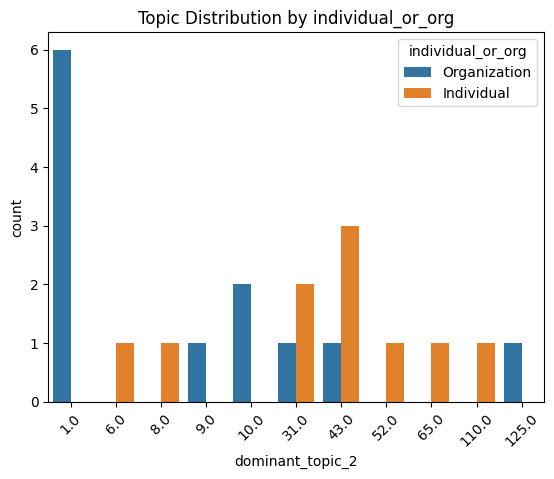

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=combined_df, x='dominant_topic_2', hue='individual_or_org')
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

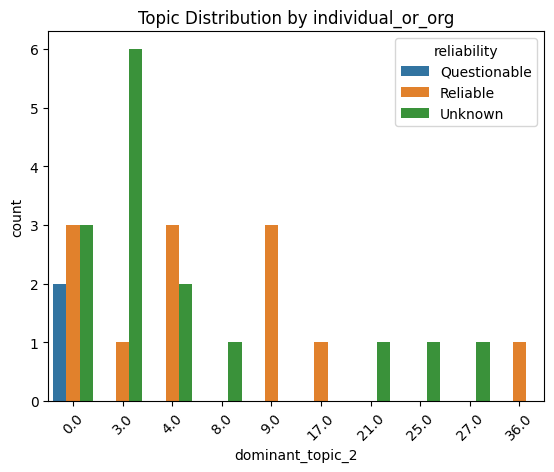

In [25]:
sns.countplot(data=combined_df, x='dominant_topic_2', hue='reliability')
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

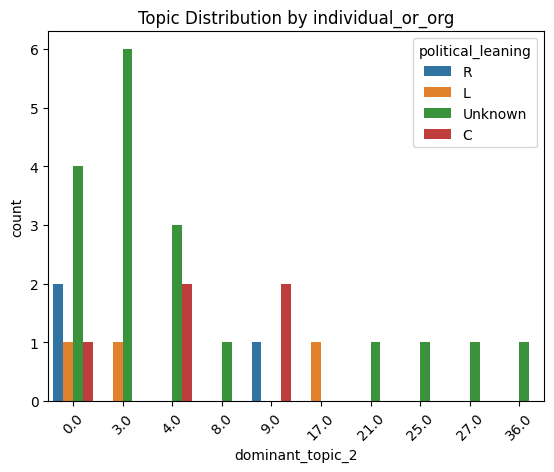

In [26]:
sns.countplot(data=combined_df, x='dominant_topic_2', hue='political_leaning')
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

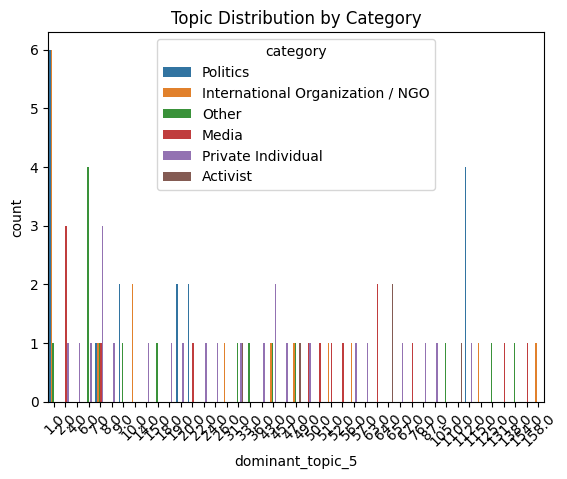

In [28]:


sns.countplot(data=combined_df, x='dominant_topic_5', hue='category')
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()


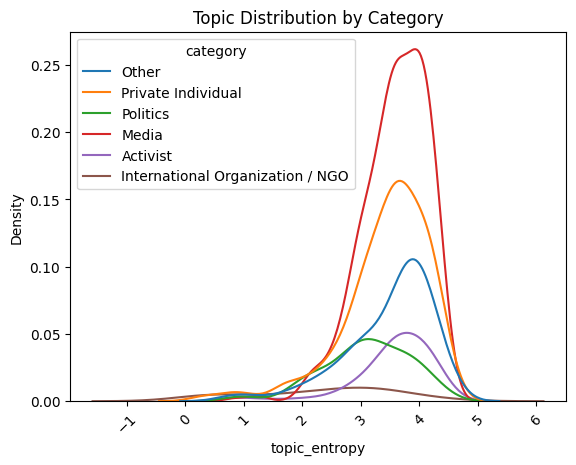

In [29]:
sns.kdeplot(data=combined_df, x='topic_entropy', hue='category')
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()

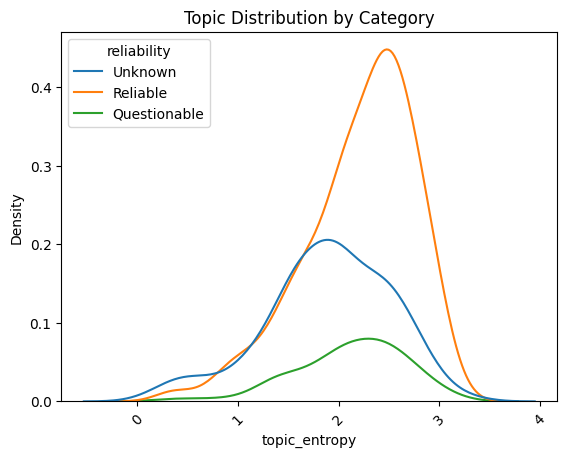

In [27]:
sns.kdeplot(data=combined_df, x='topic_entropy', hue='reliability')
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()

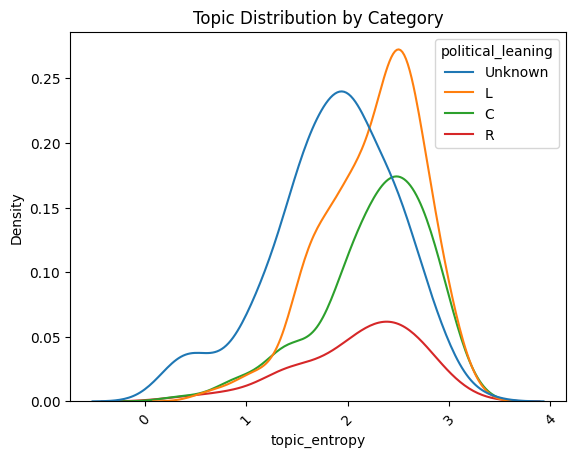

In [28]:
sns.kdeplot(data=combined_df, x='topic_entropy', hue='political_leaning')
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()

## Statistical Test for Association
### Chi²
Use Chi² for categorical association, and Cramer's V
Low p-value (e.g. < 0.05) → strong evidence that topic assignment and political leaning are not independent.
### Cramer's V 
Interpretation of effect size

|Effect size (ES) | Interpretation|
| --------- | --------- |
|ES ≤ 0.2	| The result is weak. Although the result is statistically significant, the fields are only weakly associated.|
|0.2 < ES ≤ 0.6	| The result is moderate. The fields are moderately associated.|
|ES > 0.6	| The result is strong. The fields are strongly associated.|


In [110]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))


for variable in ["reliability","political_leaning", "individual_or_org", "category"]:
    contingency_table = pd.crosstab(combined_df[variable], combined_df['dominant_topic_8'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\033[33m{variable.upper()}\033[0m")
    effect_size = cramers_v(contingency_table)
    print(f"Chi-square statistic: {chi2}, p-value: {p}")
    print(f"Cramer's V: {effect_size}")
    print(f"\033[33m{variable.title()}\033[0m and dominant topic are \033[31m{'not '*(p>0.05)}significant\033[0m and \033[31m{'weak' if effect_size<=0.2 else 'moderate' if effect_size <=0.6 else 'strong'}ly associated\033[0m.")
    print()

RELIABILITY
Chi-square statistic: 104.03132574745929, p-value: 0.026120378042065524
Cramer's V: 0.312982321943
Reliability and dominant topic are significant and moderately associated.

POLITICAL_LEANING
Chi-square statistic: 179.55278218956192, p-value: 0.0001789838440886646
Cramer's V: 0.3357284779643138
Political_Leaning and dominant topic are significant and moderately associated.

INDIVIDUAL_OR_ORG
Chi-square statistic: 105.44561624493795, p-value: 4.992173387672946e-08
Cramer's V: 0.4452033755186405
Individual_Or_Org and dominant topic are significant and moderately associated.

CATEGORY
Chi-square statistic: 378.47290443305985, p-value: 7.286565412482291e-14
Cramer's V: 0.3772042507440045
Category and dominant topic are significant and moderately associated.



/tmp/ipykernel_153288/3051319931.py:17: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  print(f"\033{variable.title()}\033 and dominant topic are \033{'not '*(p>0.05)}significant\033 and \033{'weak' if effect_size<=0.2 else 'moderate' if effect_size <=0.6 else 'strong'}ly associated\033.")
/tmp/ipykernel_153288/3051319931.py:17: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  print(f"\033{variable.title()}\033 and dominant topic are \033{'not '*(p>0.05)}significant\033 and \033{'weak' if effect_size<=0.2 else 'moderate' if effect_size <=0.6 else 'strong'}ly associated\033.")
/tmp/ipykernel_153288/3051319931.py:17: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  print(f"\033{variable.title()}\033 and dominant topic are \033{'not '*(p>0.05)}significant\033 and \033{'weak' if effect_size<=0.2 else 'moderate' if effect_si

## Tests for difference in distribution

### Mann-Whitney U test
>- Null hypothesis: The probability that a randomly chosen observation from group A is greater than one from group B is equal to the probability it is less.
>- Equivalently, the two distributions are equal in location and shape (assuming continuous data with no ties).
> - tldr: 
>   - two-sided alternative: one distribution **stochastically dominates** the other.
>   - greater (less) alternative: A (B) **tends to have larger values than** B (A).

If distributions differ in spread or shape, the test can still reject, even if medians are the same.

If shapes are identical, then rejecting can be interpreted as a shift in central tendency.
#### Two-sided alternative interpretation
- p < α (e.g., 0.05): Evidence that the two distributions differ (in central location and/or shape).
- p ≥ α: No strong evidence against equality — but lack of evidence is not evidence of equality.
#### One-sided interpretation
With a *greater* alternative, it follows that:

- H₀: Distribution of A is the same as B.
- H₁: Distribution of A is shifted to the right of B (i.e., values in A tend to be larger than in B).
- p < α → Evidence that A tends to have larger values than B.
- p ≥ α → No evidence that A is larger (but could still be smaller or equal).



In [75]:
combined_df.columns

Index(['id', 'username', 'individual_or_org', 'category', 'num_of_rt',
       'num_of_retweeters', 'V1', 'followers_count', 'following_count',
       'tweet_count', 'listed_count', 'topic_entropy',
       'effective_topic_number', 'dominant_topic_2', 'dominant_topic_3',
       'dominant_topic_4', 'dominant_topic_5', 'dominant_topic_6',
       'dominant_topic_8', 'dominant_topic_30', 'dominant_topic_50',
       'dominant_topic_60', 'political_leaning', 'reliability'],
      dtype='object')

In [92]:
import pandas as pd
from scipy.stats import mannwhitneyu

def rank_biserial_from_u(u_stat, nx, ny):
    """
    Compute rank-biserial correlation from Mann–Whitney U statistic.
    Formula: r_rb = 1 - (2U) / (n_x * n_y)
    """
    return 1 - (2 * u_stat) / (nx * ny)

for variable in ["reliability"]:#"political_leaning", "individual_or_org", "category"]:

    A = combined_df[combined_df['reliability']=='Reliable']["topic_entropy"]
    B = combined_df[combined_df['reliability']=='Questionable']["topic_entropy"]


    # Mann-Whitney U test
    # alternative can be 'two-sided', 'less', or 'greater'
    u_stat, p_value = mannwhitneyu(A, B, alternative='two-sided')
    r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
    print(f"Mann–Whitney U statistic: {u_stat}")
    print(f"P-value: {p_value:.5f}")
    print(f"Rank Biserial Correlation: {r_rb:.5f}")

    # Optional: interpret
    if p_value < 0.05:
        print("Likely difference between reliable and questionable users (p < 0.05).")
    else:
        print("No significant difference in topic entropy between reliable and questionable users.")
    u_stat, p_value = mannwhitneyu(A, B, alternative='greater')
    if p_value < 0.05:
        print("reliable users' topic entropy \33[31mstochastically dominates\33[0m questionable's (p < 0.05).")
    u_stat, p_value = mannwhitneyu(A, B, alternative='less')
    if p_value < 0.05:
        print("reliable users' topic entropy \33[34mis stochastically dominated\33[0m by questionable's (p < 0.05).")
    print()

Mann–Whitney U statistic: 10807.0
P-value: 0.15763
Rank Biserial Correlation: -0.11424
No significant difference in topic entropy between reliable and questionable users.



In [91]:
for leaning_a,leaning_b in [("R","L"), ("R","C"), ("C","L"), ("R","Unknown"),("C","Unknown"),("L","Unknown")]:#"political_leaning", "individual_or_org", "category"]:

    A = combined_df[combined_df['political_leaning']==leaning_a]["topic_entropy"]
    B = combined_df[combined_df['political_leaning']==leaning_b]["topic_entropy"]


    # Mann-Whitney U test
    # alternative can be 'two-sided', 'less', or 'greater'
    u_stat, p_value = mannwhitneyu(A, B, alternative='two-sided')
    r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
    print(f"Mann–Whitney U statistic: {u_stat}")
    print(f"P-value: {p_value:.5f}")
    print(f"Rank Biserial Correlation: {r_rb:.5f}")

    if p_value < 0.05:
        print(f"\33[33mLikely difference\33[0m between {leaning_a} and {leaning_b} -leaning users (p < 0.05).")
    else:
        print(f"No significant difference detected between {leaning_a} and {leaning_b} -leaning users.")
    u_stat, p_value = mannwhitneyu(A, B, alternative='greater')
    if p_value < 0.05:
        print(f"{leaning_a}-leaning users' topic entropy \33[31mstochastically dominates\33[0m {leaning_b}'s (p < 0.05).")
    u_stat, p_value = mannwhitneyu(A, B, alternative='less')
    if p_value < 0.05:
        print(f"{leaning_a}-leaning users' topic entropy \33[34mis stochastically dominated\33[0m by {leaning_b}'s (p < 0.05).")
    print()


Mann–Whitney U statistic: 3949.0
P-value: 0.18598
Rank Biserial Correlation: 0.12244
No significant difference detected between R and L -leaning users.

Mann–Whitney U statistic: 2610.0
P-value: 0.10355
Rank Biserial Correlation: 0.15806
No significant difference detected between R and C -leaning users.

Mann–Whitney U statistic: 11646.0
P-value: 0.51919
Rank Biserial Correlation: -0.04355
No significant difference detected between C and L -leaning users.

Mann–Whitney U statistic: 6435.0
P-value: 0.00624
Rank Biserial Correlation: -0.24951
Likely difference between R and Unknown -leaning users (p < 0.05).
R-leaning users' topic entropy stochastically dominates Unknown's (p < 0.05).

Mann–Whitney U statistic: 17841.0
P-value: 0.00000
Rank Biserial Correlation: -0.39688
Likely difference between C and Unknown -leaning users (p < 0.05).
C-leaning users' topic entropy stochastically dominates Unknown's (p < 0.05).

Mann–Whitney U statistic: 25453.0
P-value: 0.00000
Rank Biserial Correlati

In [87]:
combined_df['individual_or_org'].unique()

array(['Individual', 'Organization'], dtype=object)

In [122]:
A = combined_df[combined_df['individual_or_org']=='Individual']["topic_entropy"]
B = combined_df[combined_df['individual_or_org']=='Organization']["topic_entropy"]


# Mann-Whitney U test
# alternative can be 'two-sided', 'less', or 'greater'
u_stat, p_value = mannwhitneyu(A, B, alternative='two-sided')
r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
print(f"Mann–Whitney U statistic: {u_stat}")
print(f"P-value: {p_value:.5f}")
print(f"Rank Biserial Correlation: {r_rb:.5f}")

# Optional: interpret
if p_value < 0.05:
    print("\033[31mLikely difference\033[0m between reliable and Organization users (p < 0.05).")
else:
    print("\033[35mNo significant difference\033[0m in topic entropy between Individual and Organization users.")
u_stat, p_value = mannwhitneyu(A, B, alternative='greater')
if p_value < 0.05:
    print("Individual users' topic entropy \33[31mstochastically dominates\33[0m Organization's (p < 0.05).")
u_stat, p_value = mannwhitneyu(A, B, alternative='less')
if p_value < 0.05:
    print("Individual users' topic entropy \33[36mis stochastically dominated\33[0m by Organization's (p < 0.05).")


Mann–Whitney U statistic: 35328.0
P-value: 0.09292
Rank Biserial Correlation: 0.08287
No significant difference in topic entropy between Individual and Organization users.
Individual users' topic entropy is stochastically dominated by Organization's (p < 0.05).


In [123]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

def cliffs_delta(x, y):
    """
    Compute Cliff's delta: probability(x > y) - probability(x < y).
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n_x, n_y = len(x), len(y)
    greater = np.sum(x[:, None] > y[None, :])
    less    = np.sum(x[:, None] < y[None, :])
    delta = (greater - less) / (n_x * n_y)
    return delta

def rank_biserial_from_u(u_stat, nx, ny):
    """
    Compute rank-biserial correlation from Mann–Whitney U statistic.
    Formula: r_rb = 1 - (2U) / (n_x * n_y)
    """
    return 1 - (2 * u_stat) / (nx * ny)

def compare_groups(x, y, alternative='two-sided', alpha=0.05):
    """
    Compare two numeric sequences using Mann–Whitney U test,
    Cliff's delta, and rank-biserial correlation.
    Prints results with interpretation.
    """
    x = pd.Series(x).dropna()
    y = pd.Series(y).dropna()
    
    # Mann–Whitney U
    u_stat, p_value = mannwhitneyu(x, y, alternative=alternative)
    
    # Effect sizes
    delta = cliffs_delta(x, y)
    r_rb = rank_biserial_from_u(u_stat, len(x), len(y))
    
    # Interpretations
    print(f"Sample sizes: n_x = {len(x)}, n_y = {len(y)}")
    print(f"Mann–Whitney U: {u_stat:.3f}, p = {p_value:.5f} (alternative = '{alternative}')")
    
    if p_value < alpha:
        if alternative == 'two-sided':
            direction = "different"
        elif alternative == 'greater':
            direction = "larger" if delta > 0 else "smaller"
        elif alternative == 'less':
            direction = "smaller" if delta < 0 else "larger"
        print(f"→ Statistically significant: x appears {direction} than y (α={alpha})")
    else:
        print(f"→ No statistically significant difference detected at α={alpha}")
    
    # Cliff's delta interpretation
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        magnitude = "\033[34mnegligible\033[0m"
    elif abs_delta < 0.33:
        magnitude = "\033[36msmall\033[0m"
    elif abs_delta < 0.474:
        magnitude = "\033[33mmedium\033[0m"
    else:
        magnitude = "\033[31mlarge\033[0m"
    
    print(f"Cliff's delta: {delta:.3f} ({magnitude} effect)")
    
    # Rank-biserial interpretation (similar scale as correlation)
    print(f"Rank-biserial correlation: {r_rb:.3f} "
          f"(ranges -1 to 1; 0 means no difference)")
    

# Example usage


compare_groups(A, B, alternative='two-sided')

Sample sizes: n_x = 240, n_y = 321
Mann–Whitney U: 35328.000, p = 0.09292 (alternative = 'two-sided')
→ No statistically significant difference detected at α=0.05
Cliff's delta: -0.083 (negligible effect)
Rank-biserial correlation: 0.083 (ranges -1 to 1; 0 means no difference)
